# Modelowanie statystyczne

> WSB-NLU, 2024  
> Prowadządza: Dr hab. Elżbieta Kubińska

> Autor: Andrzej Kocielski  
> [akocielski@student.wsb-nlu.edu.pl](akocielski@student.wsb-nlu.edu.pl), [and.koc001@gmail.com](and.koc001@gmail.com)
____

## Zaimportowanie potrzebnych modułów

In [1]:
# do manipulacji ścieżkami do katalogów i plików
import os

# do obliczń numerycznych i analizy statystycznej
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels as sm
import pingouin as pg
from sklearn.linear_model import LinearRegression

# do wizualizacji danych
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# zmiana wyświetlania liczb do trzech liczb po przecinku, bez notacji naukowej
# pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Załadowanie danych surowych
Dane tygodniowe dla wybranych spółek oraz indeksów w okresie od 01.01.2023 do 15.12.2023. Źródło danych: [stooq.pl](https://stooq.pl/).

In [3]:
# Ścieżka do danych
directory_path = 'dane-finansowe'

# Lista plików csv
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

print(f"Lista plików csv:")
for i, file in enumerate(csv_files):
    print(f"{i+1}. {file}") 

Lista plików csv:
1. comarch_w.csv
2. kghm_w.csv
3. eurpln_w.csv
4. spx_w.csv
5. echo_w.csv
6. xaupln_w.csv
7. apator_w.csv
8. wig_w.csv


In [4]:
# Przygotowanie danych roboczych

# Inicjalizaja pustego DataFrame
merged_df = pd.DataFrame()

# Zaczytanie danych z poszczególnych plików csv i dodanie do wspólnego DataFrame
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)

    # Dodanie nazwy poliku do nazwy kolumny (poza pierwszą, czyli datą)
    nazwa_pliku = os.path.splitext(os.path.basename(file))[0][:-2].upper()
    df.columns = [df.columns[0]] + [f"{col}_{nazwa_pliku}" for col in df.columns[1:]]
    
    # Łączenie danych z poszczególnych plików 
    merged_df = pd.concat([merged_df, df], ignore_index=False, axis=1)

# Usunięcie powtórzonych kolumn z datami
merged_df = merged_df.T.drop_duplicates().T


In [5]:
# Zmiana typu danych 
cols = list(merged_df.columns)
cols.remove('Data')
for col in cols:
    merged_df[col] = merged_df[col].astype(float)

merged_df['Data'] = pd.to_datetime(merged_df['Data'])

# ustawienie daty jako indeksu
merged_df.set_index('Data', inplace=True)

In [ ]:
print(f"Liczba obserwacji (wierszy): {merged_df.shape[0]}, liczba kolumn: {merged_df.shape[1]}")

In [ ]:
print(f"Podgląd kilku pierwszych wierszy:")
merged_df.head()

In [ ]:
# sprawdzamy brakujące dane (ich liczbę) w poszczególnych kolumnach 
merged_df.isnull().sum() 

___
## Interpretacja graficzna danych

In [81]:
# ogólne ustawienie stylu wykresów
# print(plt.style.available)
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 1.2

### Zamknięcia sesji - szereg czasowy

In [65]:
# przygotowanie podzbioru 
zamkniecia = ['Zamkniecie_COMARCH', 'Zamkniecie_KGHM', 'Zamkniecie_EURPLN', 'Zamkniecie_SPX', 'Zamkniecie_ECHO', 'Zamkniecie_XAUPLN', 'Zamkniecie_APATOR', 'Zamkniecie_WIG']
zamkniecia_df = merged_df[zamkniecia]

spolki = ['Zamkniecie_COMARCH', 'Zamkniecie_KGHM', 'Zamkniecie_ECHO', 'Zamkniecie_APATOR']
spolki_df = merged_df[spolki]

### Zmienność wartości spółek w badanym okresie

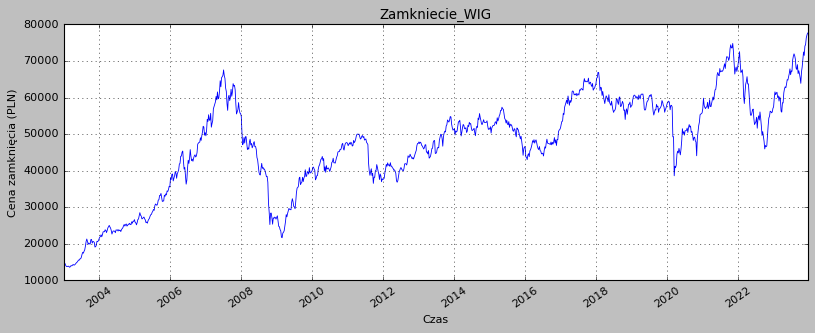

In [82]:
# wartość indeksu WIG w badanym okrecie
walor = zamkniecia_df.columns[-1] 

# dane
plt.plot(zamkniecia_df[walor]) 

plt.title(f'{walor}')
plt.xlabel('Czas')
plt.ylabel('Cena zamknięcia (PLN)')
plt.xticks(rotation=35)  
plt.grid(True, linestyle='dotted')

plt.show()

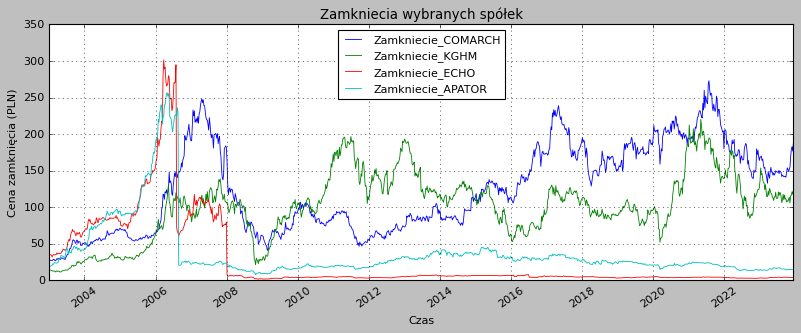

In [83]:
# wartość danego waloru w badanym okrecie
for walor in range(len(spolki_df.columns)):
    plt.plot(zamkniecia_df[spolki_df.columns[walor]], label=spolki_df.columns[walor]) 

plt.title(f'Zamkniecia wybranych spółek')
plt.xlabel('Czas')
plt.ylabel('Cena zamknięcia (PLN)')
plt.xticks(rotation=35)  
plt.grid(True,linestyle='dotted') 
plt.legend(fontsize='10', loc='upper center')

plt.show()

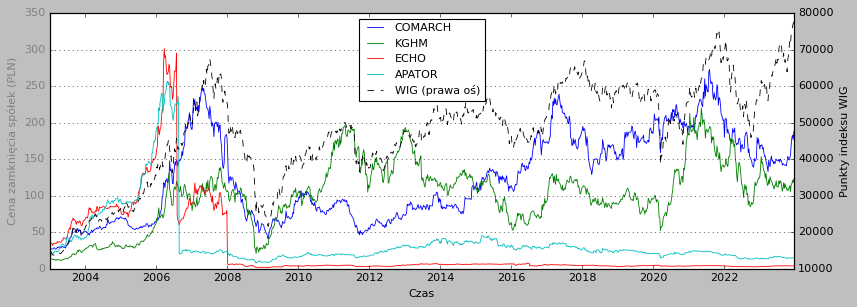

In [89]:
# Create the first plot
fig, ax1 = plt.subplots()

# Plot the first dataset on the lebt y-axis
for walor in range(len(spolki_df.columns)):
    ax1.plot(zamkniecia_df[spolki_df.columns[walor]], linestyle='-', label=spolki_df.columns[walor][11:]) 
ax1.set_xlabel('Czas')
ax1.set_ylabel('Cena zamknięcia spółek (PLN)', color='grey')
ax1.tick_params('y', colors='grey')

# Create the second plot sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second dataset on the right y-axis
wig = zamkniecia_df.columns[-1]
ax2.plot(zamkniecia_df[wig], color='black', linestyle='--', label=f'{wig[11:]} (prawa oś)')
ax2.set_ylabel('Punkty indeksu WIG', color='black')
ax2.tick_params('y', colors='black')

# Show the plots
lines, labels = ax1.get_legend_handles_labels()
lines_wig, labels_wig = ax2.get_legend_handles_labels()
ax2.legend(lines + lines_wig, labels + labels_wig, fontsize='10', loc='upper center')
plt.grid(True, linestyle='dotted') 
plt.show()

___
## Statystyka opisowa
### Dla spółki Comarch (jako przykład)

In [90]:
comarch_cols = ["Otwarcie_COMARCH", "Zamkniecie_COMARCH", "Najnizszy_COMARCH", "Najwyzszy_COMARCH", "Wolumen_COMARCH"]

### Wybrane miary zmienności
- Rozstęp
- Odchylenie ćwiartkowe
- Wariancja
- Odchylenie standardowe
- Współczynnik zmienności

### Wybrane miary pozycyjne
- Średnia
- Kwantyle
- Mediana (kwantyl 50%)
- Moda

### Wybrane miary kształtu
- Skośność
- Kurtoza

In [95]:
# własna funkcja do obliczania inter quartile range (IQR)
def q25(column):
    return column.quantile(0.25)
def q75(column):
    return column.quantile(0.75)    
def IQR(column): 
    q25, q75 = column.quantile([0.25, 0.75])
    return q75-q25

# własna funkcja do obliczania zakresu
def range_max_min(column):
    return column.max() - column.min()

# własna funkcja do obliczania współczynnika zmienności (coefficient of variance)
def cv(column):
    return stats.variation(list(column)) * 100

# własna funkcja do wyznaczania błędu standardowego
def sem(column):
    return stats.sem(list(column))

# własna funkcja do wyznaczenia przedziału ufności dla średniej
def ci(column):
    conf_level = 0.95
    df = len(column) - 1
    sem = stats.sem(list(column))
    # return stats.t.interval(conf_level, df, np.mean(column), sem)

    lower, upper = stats.t.interval(conf_level, df, np.mean(column), sem)
    lower = round(lower, 3)
    upper = round(upper, 3)
    return lower, upper

charakterystyka = ["min", q25, "mean", "median", q75, IQR, "max", range_max_min, "var", "std", cv, sem, ci, "skew", "kurtosis"]

In [96]:
merged_df[comarch_cols].agg(charakterystyka)

,Otwarcie_COMARCH,Zamkniecie_COMARCH,Najnizszy_COMARCH,Najwyzszy_COMARCH,Wolumen_COMARCH
min,26.499668,26.998967,25.000256,27.299035,414.209002
q25,69.999972,69.999972,68.000212,71.962575,8167.88004
mean,124.925244,124.790129,120.492354,128.679422,31502.620402
median,116.958847,117.210668,112.853738,119.996195,16970.808795
q75,176.000308,175.999543,169.147666,179.99597,36870.601798
IQR,106.000336,105.999572,101.147453,108.033395,28702.721758
max,274.999921,272.999654,260.000021,279.999537,431401.754479
range_max_min,248.500253,246.000687,234.999765,252.700501,430987.545477
var,3521.851876,3496.816984,3266.162422,3724.534171,1853908016.174635
std,59.345193,59.13389,57.150349,61.028962,43057.032134


### Interpretacja wybranych statystyk dla _cen zamknięcia_ akcji Comarch w interwałach tygodniowych

$min$ -> najniższa cena akcji Comarch na zamknięciu tygodniowym w obserwowanym okresie

$max$ -> najwyższa cena akcji na zamknięciu tygodniowym 

$mean$ -> średnia arytmetyczna cen zamknięcia

$median$ -> mediana (wartość środkowa); wartość mniejsza od średniej wskazuje na skośność statystyki

$std$ -> odchylenie standardowe wyrażone w PLN; stosunkowo duża wartość $std$ w stosunku do średniej wskazuje na znaczny rozrzut zmiennej 

$cv$ -> współczynnik zmienności; średnia / odchylenie standardowe

$sem$ -> błąd standardowy średniej; rozrzut estymatorów z próby wokół parametru populacji, czyli jak bardzo średnia próbki jest "rozmyta" (miara niepewności testu)

$ci$ -> przedział ufności; z prawdopodobieństwem 0.95 prawdziwa wartość parametru populacyjnego (średnia cen zamknięcia) znajduje się w tym przedziale

$skew$ -> skośność; wartość większa od 1 świadczy o skośności lewostronnej

$kurtosis$ -> kurtoza; bada czy rozkład jest płaski, czy stromy; kurtoza < 0 wskazuje na rozkład platykurtyczny, czyli rozkład niski i szeroki (Wartości zmiennej są bardziej rozrzucone wokół średniej oraz mamy mniejsze prawdopodobieństwo wystąpienia wartości ekstremalnych)


___
## Analiza kursu EUR - PLN
### Histogram

In [99]:
np.min(merged_df['Zamkniecie_EURPLN'])

3.2038

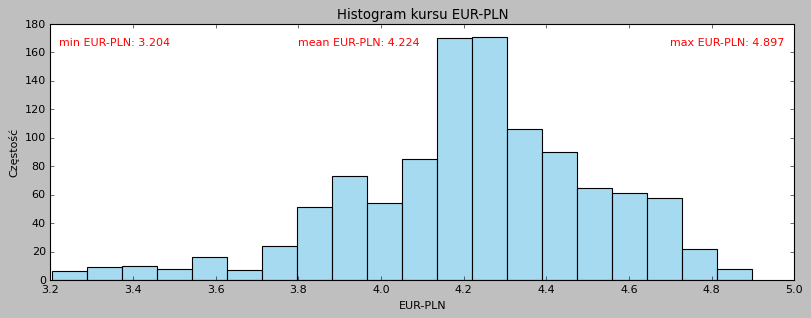

In [129]:
# Utwórzenie histogram
sns.histplot(merged_df['Zamkniecie_EURPLN'], bins=20, kde=False, color='skyblue')

# Opis wykresu i osi
plt.title('Histogram kursu EUR-PLN')
plt.xlabel('EUR-PLN')
plt.ylabel('Częstość')
plt.text(3.22, 165, f'min EUR-PLN: {np.min(merged_df["Zamkniecie_EURPLN"]):.3f}', color='red')
plt.text(4.7, 165, f'max EUR-PLN: {np.max(merged_df["Zamkniecie_EURPLN"]):.3f}', color='red')
plt.text(3.8, 165, f'mean EUR-PLN: {np.mean(merged_df["Zamkniecie_EURPLN"]):.3f}', color='red')
plt.show()

### Wyznaczenie trzech sigm dla cen zamknięcia EUR-PLN

In [ ]:
# Dystrybuanta dla cen zamknięcia EUR-PLN
mean =  np.mean(merged_df["Zamkniecie_EURPLN"])
std_dev = np.std(merged_df["Zamkniecie_EURPLN"], ddof=1)

# Wartości Z-score dla trzech odchyleń standardowych
z_scores = [-3, -2, -1, 1, 2, 3]

print(f'Średnia: {mean:.4f}')
print(f'Odchylenie standardowe: {std_dev:.4f}')

# Oblicz dystrybuantę dla odchyleń standardowych (wartość Z-score)
sigmy = [z * std_dev + mean for z in z_scores]
for z in sigmy:
    cumulative_probability = stats.norm.cdf(z, loc=mean, scale=std_dev)
    print(f'Dystrybuanta dla {z:.4f} odchylenia standardowego: {cumulative_probability:.4f}')


# Analiza graficzna trzech sigm

# Tworzenie danych dla osi X (wartości Z-score)
x_values = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 1000)

# Tworzenie wykresu statystyki
plt.figure(figsize=(10, 6))
plt.plot(x_values, norm.pdf(x_values, loc=mean, scale=std_dev), label='Gęstość rozkładu normalnego')

# wartość oczekiwana
plt.axvline(mean, color='g', linestyle='--', label=f'wartość oczekiwana = {mean:.2f}')

# Dodanie dystrybuant dla różnych odchyleń standardowych
for z in sigmy:
    plt.axvline(z, color='grey', linestyle='--', label=f'Z = {z:.4f}')

    # Obliczanie dystrybuanty dla danego Z-score
    cumulative_probability = norm.cdf(z, loc=mean, scale=std_dev)
    plt.text(.01+z, .9+z*-.17, f'P(Z<{z:.2f})={cumulative_probability:.3f}', color='grey')

# Konfiguracja wykresu
plt.title('Wykres statystyki i dystrybuanty dla trzech odchyleń standardowych EUR-PLN')
plt.xlabel('Wartość Z-score')
plt.ylabel('Gęstość prawdopodobieństwa')
plt.legend()
plt.grid(True)
plt.show()

___
## Testy statystyczne
### Czy częstość występowania cen EUR-PLN ma rozkład normalny

In [ ]:
# Test Kołmogorowa-Smirnowa
statistic, p_value = stats.kstest(merged_df['Zamkniecie_EURPLN'], 'norm')
print("Statystyka testowa:", statistic)
print("Wartość p:", p_value)

# Interpretacja wyników
alpha = 0.05
if p_value > alpha:
    print("Nie ma podstaw do odrzucenia hipotezy zerowej (o normalności rozkładu).")
else:
    print("Odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).")

In [ ]:
# Test D'Agostino i Pearson:
statistic, p_value = stats.normaltest(merged_df['Zamkniecie_EURPLN'])

print("Statystyka testowa:", statistic)
print("Wartość p:", p_value)

# Interpretacja wyników
alpha = 0.05
if p_value > alpha:
    print("Nie ma podstaw do odrzucenia hipotezy zerowej (rozklad normalny).")
else:
    print("Odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).")

___
## Analiza portfelowa
Na przykładzie cen zamknięcia spółki Comarch wobec indeksu WIG

### Wyznaczenie korelacji

In [238]:
# Dane (zmienne niezależne i zależna)
x = merged_df['Zamkniecie_WIG']
y = merged_df['Zamkniecie_COMARCH']

# Obliczenie współczynnika korelacji (Pearson)
correlation_coefficient = np.corrcoef(x, y)[0, 1]
# Wyświetlenie współczynnika korelacji
print(f'Współczynnik korelacji: {correlation_coefficient:.2f}')

Współczynnik korelacji: 0.80


### Model regresji liniowej

Współczynnik nachylenia (a): [0.73127588]
Wyraz wolny (b): [0.00144535]
Współczynnik determinacji (R^2): 0.1844239019603393


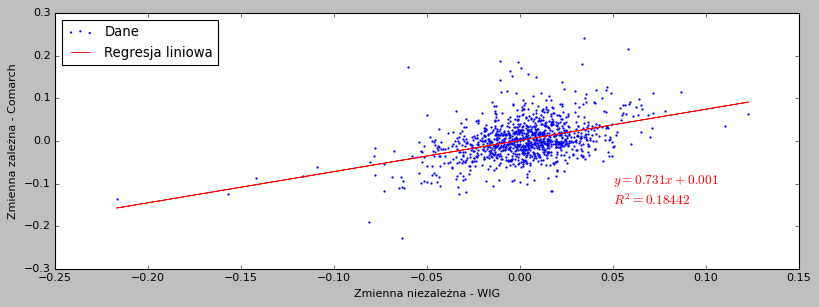

In [255]:
# Przekształcenie elementów serii, tak aby uzyskać procentową zmianę między elementami, tj. (bierzący/poprzedni - 1) 
x = merged_df['Zamkniecie_WIG'].pct_change().dropna()
y = merged_df['Zamkniecie_COMARCH'].pct_change().dropna()  

# Przekształcenie danych do postaci wymaganej przez scikit-learn
X = x.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

# Inicjalizacja modelu regresji liniowej
model = LinearRegression()

# Dopasowanie modelu do danych
model.fit(X, y)

# Wyświetlenie wyników regresji
print("Współczynnik nachylenia (a):", model.coef_[0])
print("Wyraz wolny (b):", model.intercept_)
print("Współczynnik determinacji (R^2):", model.score(X, y))

# Dodanie równania regresji liniowej na wykresie
equation = f'$y = {float(model.coef_[0]):.3f}x + {float(model.intercept_):.3f}$'
plt.annotate(equation, xy=(0.05, -.1), fontsize=12, color='red')
r = f'$R^2 = {model.score(X, y):.5f}$'
plt.annotate(r, xy=(0.05, -.15), fontsize=12, color='red')

# Wykres danych i regresji
plt.scatter(x, y, color='blue', label='Dane', s=1)
plt.plot(x.values.reshape(-1, 1), model.predict(X), color='red', label='Regresja liniowa')
plt.xlabel('Zmienna niezależna - WIG')
plt.ylabel('Zmienna zależna - Comarch')
plt.legend(loc='upper left')
# plt.xlim(10000, 80000) 
# plt.ylim(0, 300)
plt.show()

___
## Dodatkowe źródła
- [https://mateuszgrzyb.pl/3-metody-analizy-normalnosci-rozkladu-w-python/](https://mateuszgrzyb.pl/3-metody-analizy-normalnosci-rozkladu-w-python/)
- [https://github.com/bilalonur/financial-visualization/blob/main/finance-visualization.ipynb](https://github.com/bilalonur/financial-visualization/blob/main/finance-visualization.ipynb)
- [https://python.cogsci.nl/numerical/statistics/](https://python.cogsci.nl/numerical/statistics/)
- [https://pingouin-stats.org/](https://pingouin-stats.org/)
- [https://www.naukowiec.org/wiedza/statystyka/](https://www.naukowiec.org/wiedza/statystyka/)

___
Andrzej Kocielski, 2024